# Multinomial logistic regression

Let $\mathcal Y$ be a finite set, e.g. $\mathcal Y=\{1, 2, \ldots, K\}$, and the training dataset

$$
\mathcal D = \{(\boldsymbol x_i, y_i)\}_{i=1}^n, \quad \boldsymbol x_i\in\mathbb R^d, \quad y_i\in \mathcal Y.
$$

Multinomial logistic regression predicts a vector of probabilities

$$
    \boldsymbol{\widehat y} = (p_1,\ldots, p_K), \quad  p_k > 0, \quad \sum\limits_{k=1}^K p_k = 1.
$$

How to predict these probabilities? We can use a linear model whose output is a vector of $K$ different numbers:

$$
z_k = \boldsymbol x^\top \boldsymbol w_k, \quad \boldsymbol w_k \in \mathbb R^d, \quad
k = 1, \ldots, K.
$$

Now convert the vector $\boldsymbol z \in \mathbb R^K$ to the vector of probabilities $\boldsymbol{\widehat y}$ via **softmax**:

$$
\boldsymbol{\widehat y} = \mathrm{Softmax}(\boldsymbol z) = \bigg(\frac{e^{z_1}}{\sum e^{z_k}}, \ldots, \frac{e^{z_K}}{\sum e^{z_k}}\bigg)
$$

If we need to pick a class, we can choose the most probable one:

$$
    \arg\max\limits_{1\leqslant k \leqslant K} p_k = 
    \arg\max\limits_{1\leqslant k \leqslant K} \Big\{\frac{\exp(\boldsymbol x^\top \boldsymbol w_k)}{\sum \exp(\boldsymbol x^\top \boldsymbol w_k)}\Big\}
$$

The parameters $\boldsymbol w_k$ naturally form a matrix

$$
    \boldsymbol W = [\boldsymbol w_1 \ldots \boldsymbol w_K]
$$

**Q**. What is the shape of this matrix? How many parameters does multinomial regression have?





## Loss function

The optimal parameters $\boldsymbol W$ are solutions of the following optimization problem:

```{math}
:label: multi-log-reg-opt
\mathcal L (\boldsymbol W) = \sum\limits_{i=1}^n  \bigg(\boldsymbol x_i^\top\boldsymbol w_{y_i} -\log\Big(\sum\limits_{k=1}^K \exp(\boldsymbol x_i^\top\boldsymbol w_{k})\Big)\bigg) \to \max\limits_{\boldsymbol w_{1}, \ldots, \boldsymbol w_{K}}
```
    


If the targets $y_k$ are one-hot encoded, then they from a matrix

$$
    \boldsymbol Y = \begin{pmatrix}
    \boldsymbol y_1^\top \\
    \vdots \\
     \boldsymbol y_n^\top
    \end{pmatrix},
    \quad
    y_{ik} \geqslant 0, \quad \sum\limits_{k=1}^K y_{ik} = 1.
$$

Accordingly, the loss function {eq}`multi-log-reg-loss` can be written as

```{math}
:label: multi-log-reg-loss
\mathcal L (\boldsymbol W) = \sum\limits_{i=1}^n \sum\limits_{k=1}^K  y_{ik}\log\bigg(\frac{\exp(\boldsymbol x_i^\top\boldsymbol w_k)}{\sum\limits_{1 \leqslant k \leqslant K}\exp(\boldsymbol x_i^\top\boldsymbol w_{k})}\bigg) =  \sum\limits_{i=1}^n \sum\limits_{k=1}^K  y_{ik} \log \widehat y_{ik},
```

and this is generally the cross-entropy loss {eq}`cross-entropy`, taken with opposite sign.

````{admonition} Question
:class: important
Denote $\boldsymbol{\widehat Y} = (\widehat y_{ik}) = \mathrm{Softmax}(\boldsymbol {XW})$ (softmax is applied to each row). Rewrite the loss function {eq}`multi-log-reg-loss` in matrix form.

```{admonition} Answer
:class: tip, dropdown
$$
\sum\limits_{i=1}^n \sum\limits_{k=1}^K  y_{ik} \log \widehat y_{ik} = \mathrm{tr} (\boldsymbol Y^\top \boldsymbol {\widehat Y}).
$$
```
````

Regularized version:

$$
\sum\limits_{i=1}^n  \Big(\boldsymbol x_i^\top\boldsymbol w_{y_i} -\sum\limits_{k=1}^K \exp(\boldsymbol x_i^\top\boldsymbol w_{k})\Big) - C\Vert \boldsymbol W \Vert_F^2 \to \max\limits_{\boldsymbol W}, \quad C > 0.
$$

**Q**. Why do we see minus before the regularization term?

## Example: MNIST

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'svg'

X, Y = fetch_openml('mnist_784', return_X_y=True, parser='auto')

X = X.astype(float).values / 255
Y = Y.astype(int).values

### Visualize data

Visualize some random samples:

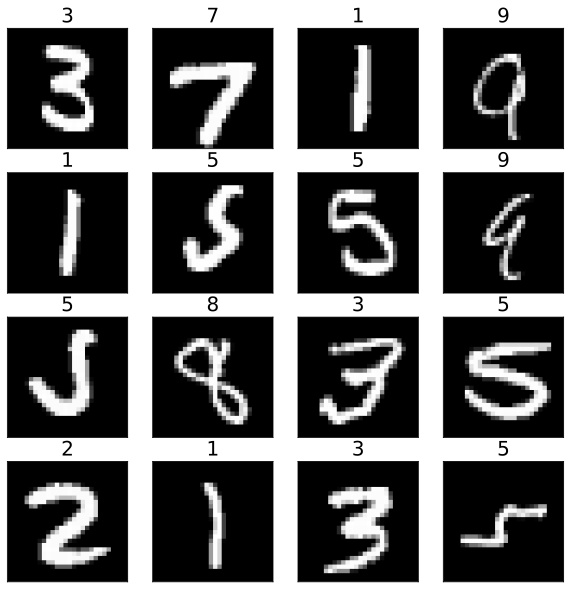

In [4]:
def plot_digits(X, y_true, y_pred=None, n=4, random_state=123):
    np.random.seed(random_state)
    indices = np.random.choice(np.arange(X.shape[0]), size=n*n, replace=False)
    plt.figure(figsize=(10, 10))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        # plt.imshow(train_images[i], cmap=plt.cm.binary)
        if y_pred is None:
            title = str(y_true[indices[i]])
        else:
            title = f"y={y_true[indices[i]]}, ŷ={y_pred[indices[i]]}"
        plt.title(title, size=20)
    plt.show()

plot_digits(X, Y, random_state=12)

### Splitting into train and test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=10000)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

Check that the classes are balanced:

In [6]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 945, 1233,  995, 1036,  972,  903,  970, 1000,  950,  996]))

### Fit and evaluate

Fit the logistic regression:

In [7]:
%%time
LR = LogisticRegression(max_iter=100)
LR.fit(X_train, y_train)

CPU times: user 40.8 s, sys: 1.71 s, total: 42.5 s
Wall time: 28.1 s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Make predictions:

In [8]:
y_hat = LR.predict(X_test)
y_hat

array([5, 4, 4, ..., 3, 2, 3])

We can also predict probabilities:

In [10]:
y_proba = LR.predict_proba(X_test)
y_proba[:3]

array([[1.65095773e-04, 1.43385260e-07, 1.14780168e-05, 2.99636017e-01,
        5.98926346e-07, 6.39615667e-01, 1.80372814e-07, 1.76480310e-07,
        5.86493420e-02, 1.92130044e-03],
       [1.21475181e-04, 1.49673625e-06, 1.08891109e-03, 1.24093043e-05,
        9.14920772e-01, 1.95035318e-04, 1.16798504e-04, 1.85831413e-04,
        1.03925873e-02, 7.29646828e-02],
       [9.63965076e-09, 9.52335705e-09, 1.80277138e-07, 4.04423620e-09,
        9.99908083e-01, 2.32334829e-06, 7.00253101e-06, 8.06028699e-06,
        6.62953819e-06, 6.76977960e-05]])

Calculate metrics:

In [11]:
print("Accuracy:", accuracy_score(y_test, y_hat))

Accuracy: 0.9215


(mnist-confusion-matrix)=
### Visualize performance

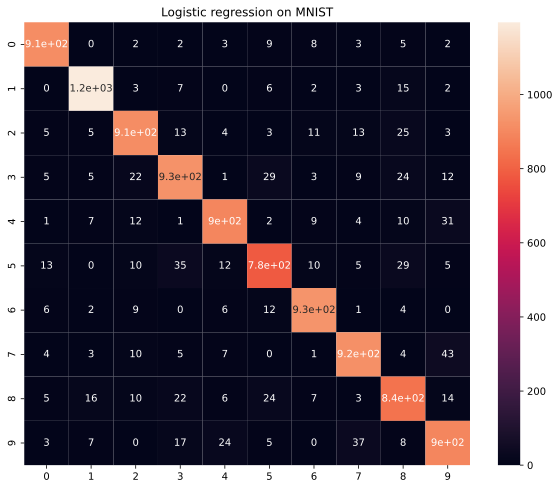

In [12]:
plt.figure(figsize=(10, 8))
plt.title("Logistic regression on MNIST")
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True);

Plot some samples with predictions and ground truths:

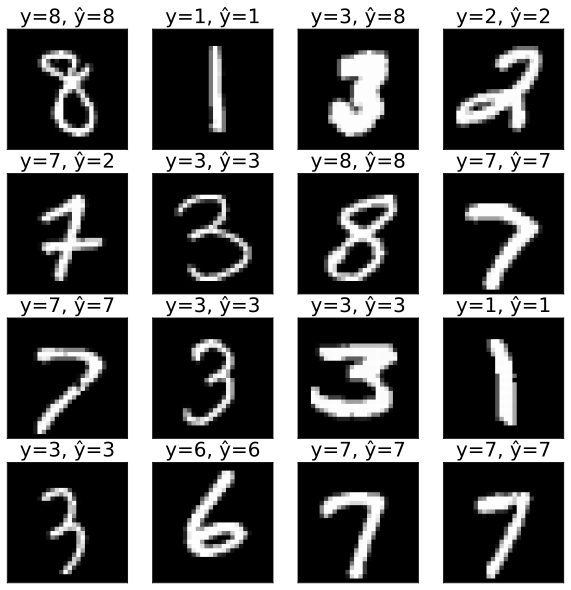

In [13]:
plot_digits(X_test, y_test, y_hat)